In [26]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows
import pandas as pd

import pyworld
import pysptk
import nnmnkwii
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)

    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))


    mgc_delta = apply_delta_windows(mgc, windows)
    
    return mgc, mgc_delta


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()
    
def node_split(alpha_init, reduction):
    
    a_1 = [alpha_init[0]*reduction, alpha_init[1], alpha_init[2]]
    a_2 = [alpha_init[0], alpha_init[1]*reduction, alpha_init[2]]
    a_3 = [alpha_init[0], alpha_init[1], alpha_init[2]*reduction]
    
    alpha_1 = a_1/sum(a_1)
    alpha_2 = a_2/sum(a_2)
    alpha_3 = a_3/sum(a_3)
    
    node_1 = np.floor(244 * alpha_1).astype(int)
    node_2 = np.floor(244 * alpha_2).astype(int)
    node_3 = np.floor(244 * alpha_3).astype(int)

    nodes = np.zeros([3,3], int)
    alphas = np.zeros([3,3], float)

    nodes[0,:] = node_1
    nodes[1,:] = node_2
    nodes[2,:] = node_3
    
    alphas[0,:] = alpha_1
    alphas[1,:] = alpha_2
    alphas[2,:] = alpha_3
   
    return nodes, alphas

def shuffle_list(input_wav_list, input_mv_list):
    
    shuffled_wav_list = {}
    shuffled_mv_list = {}
    
    keys = np.arange(len(input_wav_list))
    np.random.shuffle(keys)    
    
    i = 0

    for key in keys:

        shuffled_wav_list[i] = input_wav_list[key] 
        shuffled_mv_list[i] = input_mv_list[key] 
        
        i = i + 1
        
    return shuffled_wav_list, shuffled_mv_list
    
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

In [28]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'SDTL' # ENF or ENM or SDTL
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['DN004', 'DN011', 'DN006', 'DN008', 'DN009', 'DN005', 'DN007', 'DN010']


In [29]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]


train_index = [i for j in (range(0, 122), range(132, 254)) for i in j]
valid_index = [i for j in (range(122, 127), range(254, 259)) for i in j]
test_index = [i for j in (range(127, 132), range(259, 264)) for i in j]

In [30]:
F_Target_Sub = 'DN008'
F_Train_Sub = ['DN010', 'DN006', 'DN007']

M_Target_Sub = 'DN011'
M_Train_Sub = ['DN007','DN005', 'DN010']

In [31]:
Testing_Gender = 'M'

In [32]:
if Testing_Gender == 'F':
    Target_Sub = F_Target_Sub
    Train_Sub = F_Train_Sub
else:
    Target_Sub = M_Target_Sub
    Train_Sub = M_Train_Sub 

In [33]:
data_sub_folder = os.path.join(group_folder, Target_Sub)

Target_WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
Target_WAV_path_list = glob.glob(Target_WAV_path_list)
Target_WAV_path_list.sort()

Target_EMA_path_list = os.path.join(data_sub_folder, '*' + '.MV8')
Target_EMA_path_list = glob.glob(Target_EMA_path_list)
Target_EMA_path_list.sort()

In [34]:
Train_sub1_folder = os.path.join(group_folder, Train_Sub[0])
Train1_WAV_path_list = os.path.join(Train_sub1_folder, '*' + '.wav')
Train1_WAV_path_list = glob.glob(Train1_WAV_path_list)
Train1_WAV_path_list.sort()
Train1_EMA_path_list = os.path.join(Train_sub1_folder, '*' + '.MV8')
Train1_EMA_path_list = glob.glob(Train1_EMA_path_list)
Train1_EMA_path_list.sort()

Train_sub2_folder = os.path.join(group_folder, Train_Sub[1])
Train2_WAV_path_list = os.path.join(Train_sub2_folder, '*' + '.wav')
Train2_WAV_path_list = glob.glob(Train2_WAV_path_list)
Train2_WAV_path_list.sort()
Train2_EMA_path_list = os.path.join(Train_sub2_folder, '*' + '.MV8')
Train2_EMA_path_list = glob.glob(Train2_EMA_path_list)
Train2_EMA_path_list.sort()

Train_sub3_folder = os.path.join(group_folder, Train_Sub[2])
Train3_WAV_path_list = os.path.join(Train_sub3_folder, '*' + '.wav')
Train3_WAV_path_list = glob.glob(Train3_WAV_path_list)
Train3_WAV_path_list.sort()
Train3_EMA_path_list = os.path.join(Train_sub3_folder, '*' + '.MV8')
Train3_EMA_path_list = glob.glob(Train3_EMA_path_list)
Train3_EMA_path_list.sort()

In [35]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.genfromtxt(Target_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Target_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1 

Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.genfromtxt(Target_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Target_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1 

In [36]:
Train_MV_1 = {}
Train_WAV_1 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train1_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train1_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_1[index] = MV_delta
  Train_WAV_1[index] = WAV_delta
  
  index = index + 1 

Train_MV_2 = {}
Train_WAV_2 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train2_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train2_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_2[index] = MV_delta
  Train_WAV_2[index] = WAV_delta
  
  index = index + 1 

Train_MV_3 = {}
Train_WAV_3 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train3_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train3_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_3[index] = MV_delta
  Train_WAV_3[index] = WAV_delta
  
  index = index + 1 

In [37]:
Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [38]:
def valid_nodes(nodes, h):

    l = 0

    Val_loss_forward = np.zeros([3,1], float)
    Train_loss_forward = np.zeros([3,1], float)

    Val_loss_backward = np.zeros([3,1], float)
    Train_loss_backward = np.zeros([3,1], float)

    #################################### Forward ######################  

    for node in nodes:

        Train_MV_1_picked = {}
        Train_WAV_1_picked = {}

        Train_MV_2_picked = {}
        Train_WAV_2_picked = {}

        Train_MV_3_picked = {}
        Train_WAV_3_picked = {}


        for i in range(node[0]):        
            Train_MV_1_picked[i] = Train_MV_1[i]
            Train_WAV_1_picked[i] = Train_WAV_1[i]

        for i in range(node[1]): 

            Train_MV_2_picked[i] = Train_MV_2[i]
            Train_WAV_2_picked[i] = Train_WAV_2[i]

        for i in range(node[2]):
            Train_MV_3_picked[i] = Train_MV_3[i]
            Train_WAV_3_picked[i] = Train_WAV_3[i]

        Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
        Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

        Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

        Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
        Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

        history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = h, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
        val_loss_f = np.array(history.history['val_mean_absolute_error'])
        train_loss_f = np.array(history.history['mean_absolute_error'])

        print(val_loss_f)

        Val_loss_forward[l] = val_loss_f[h-1]
        Train_loss_forward[l] = train_loss_f[h-1]
        
    #################################### backward ######################  

    nodes_flip = np.flip(nodes, 0)

    for node in nodes:

        Train_MV_1_picked = {}
        Train_WAV_1_picked = {}

        Train_MV_2_picked = {}
        Train_WAV_2_picked = {}

        Train_MV_3_picked = {}
        Train_WAV_3_picked = {}


        for i in range(node[0]):        
            Train_MV_1_picked[i] = Train_MV_1[i]
            Train_WAV_1_picked[i] = Train_WAV_1[i]

        for i in range(node[1]): 

            Train_MV_2_picked[i] = Train_MV_2[i]
            Train_WAV_2_picked[i] = Train_WAV_2[i]

        for i in range(node[2]):
            Train_MV_3_picked[i] = Train_MV_3[i]
            Train_WAV_3_picked[i] = Train_WAV_3[i]

        Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
        Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

        Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

        Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
        Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

        history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = h, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
        val_loss_b = np.array(history.history['val_mean_absolute_error'])
        train_loss_b = np.array(history.history['mean_absolute_error'])

        print(val_loss_b)

        Val_loss_backward[l] = val_loss_b[h-1]
        Train_loss_backward[l] = train_loss_b[h-1]

        l = l+1
        
    return Val_loss_forward, Train_loss_forward, Val_loss_backward, Train_loss_backward, nodes, model
    


In [39]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [40]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(512, activation = tf.nn.relu, input_shape = (24,)),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(120)
    ])
    
    optimizer = tf.keras.optimizers.SGD(0.0025, momentum=0.9)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               12800     
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 120)               61560     
Total params: 1,124,984
Trainable params: 1,124,984
Non-trainable params: 0
_________________________________________________________________


In [41]:
max_epoch = 5
patient = 5

not_converge = 0

MnM_Validation_loss = {}
MnM_Train_loss = {}

epoch_val_loss = {}
epoch_val_loss[0] = 100000

alpha_init = np.array([0.333, 0.333, 0.333])
reduction = 0.4
nodes, alphas = node_split(alpha_init, reduction)

h = 1

for epoch in range(max_epoch):
    
    
    if not_converge <= patient:
    
        Val_loss_forward, Train_loss_forward, Val_loss_backward, Train_loss_backward, current_nodes, current_model = valid_nodes(nodes, h)
    
        total_val_loss = Val_loss_forward + np.flip(Val_loss_backward)
    
        epoch_val_loss[epoch] = sum(total_val_loss)
        
        best_node = np.argmin(total_val_loss)
        nodes, alphas  = node_split(alphas[best_node], reduction)
        
        Val_loss = np.concatenate([Val_loss_forward, Val_loss_backward])
        Tra_loss = np.concatenate([Train_loss_forward, Train_loss_backward])
    
        if epoch > 0 and epoch_val_loss[epoch] > epoch_val_loss[epoch -1]:
            not_converge = not_converge + 1
            
        h = h + 1
            
    MnM_Validation_loss[epoch] = Val_loss
    MnM_Train_loss[epoch] = Tra_loss


 
. [0.18977371]
 
. [0.18318208]
 
. [0.17328596]
 
. [0.17728661]
 
. [0.17697176]
 
. [0.17564994]
 
. . [0.17502615 0.17342362]
 
. . [0.17222731 0.17118998]
 
. . [0.17108333 0.17100883]
 
. . [0.1675221  0.16676468]
 
. . [0.16424185 0.16539232]
 
. . [0.1631358  0.16586934]
 
. . . [0.16493504 0.16354938 0.16266023]
 
. . . [0.16009057 0.15835822 0.15918696]
 
. . . [0.15641579 0.15664639 0.15866995]
 
. . . [0.16183625 0.16051058 0.16034049]
 
. . . [0.15851907 0.15808815 0.15672515]
 
. . . [0.15787005 0.15911426 0.15938564]
 
. . . . [0.16131495 0.15924557 0.16079822 0.16006385]
 
. . . . [0.15834372 0.1572248  0.15761839 0.1575748 ]
 
. . . . [0.15964308 0.15787023 0.15854631 0.16045181]
 
. . . . [0.16167456 0.15906969 0.15876432 0.15774542]
 
. . . . [0.15923385 0.15809467 0.1563672  0.15708019]
 
. . . . [0.15808989 0.1572134  0.15679155 0.1588093 ]
 
. . . . . [0.15947638 0.15898862 0.16083452 0.16051678 0.158417  ]
 
. . . . . [0.15938047 0.1592442  0.15531349 0.1585688

In [42]:
mm_model = current_model
print(h)

6


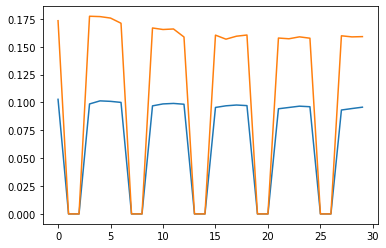

In [43]:
TTTT_loss = {}
VVVV_loss = {}

for i in range(len(MnM_Validation_loss)):
    
    TT_loss = MnM_Train_loss[i]
    TTT_loss = np.reshape(TT_loss, [TT_loss.shape[0] ,1])
    TTTT_loss[i] = TTT_loss 

    VV_loss = MnM_Validation_loss[i]
    VVV_loss = np.reshape(VV_loss, [VV_loss.shape[0] ,1])
    VVVV_loss[i] = VVV_loss
    
MnM_VVVVV_loss = np.concatenate([VVVV_loss[x] for x in VVVV_loss])
MnM_TTTTT_loss = np.concatenate([TTTT_loss[x] for x in TTTT_loss])


plt.plot(MnM_TTTTT_loss, label = 'Train Loss')
plt.plot(MnM_VVVVV_loss, label = 'Valid Loss')

In [50]:
print(MnM_VVVVV_loss)
print(epoch)

[[0.34521368]
 [0.        ]
 [0.        ]
 [0.32644987]
 [0.33456814]
 [0.31276104]
 [0.28307959]
 [0.        ]
 [0.        ]
 [0.28427804]
 [0.29116547]
 [0.27598831]
 [0.25375003]
 [0.        ]
 [0.        ]
 [0.24730086]
 [0.24969177]
 [0.23037407]
 [0.21827546]
 [0.        ]
 [0.        ]
 [0.21480961]
 [0.21509162]
 [0.20861688]]
29


In [44]:
print(current_nodes[best_node])

[121   1 121]


In [21]:
test_predictions = model.predict(Test_MV_block)

mgc_head = test_predictions[:, 0:mgc_dim]
mgc_ref = Test_WAV_block[:, 0:mgc_dim]
from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)
print(MCD)

16.97226026458831


In [76]:
max_epoch = 100


Validation_loss = {}
Train_loss = {}

for epoch in range(max_epoch):

    print("I am working")
    selected_node = current_nodes[best_node]

    Train_MV_1_picked = {}
    Train_WAV_1_picked = {}

    Train_MV_2_picked = {}
    Train_WAV_2_picked = {}

    Train_MV_3_picked = {}
    Train_WAV_3_picked = {} 

    for i in range(selected_node[0]):        
        Train_MV_1_picked[i] = Train_MV_1[i]
        Train_WAV_1_picked[i] = Train_WAV_1[i]

    for i in range(selected_node[1]): 

        Train_MV_2_picked[i] = Train_MV_2[i]
        Train_WAV_2_picked[i] = Train_WAV_2[i]

    for i in range(selected_node[2]):
        Train_MV_3_picked[i] = Train_MV_3[i]
        Train_WAV_3_picked[i] = Train_WAV_3[i]

    Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
    Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

    Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

    Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
    Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

    history = mm_model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = 1, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
    Val_loss = np.array(history.history['val_mean_absolute_error'])
    Tra_loss = np.array(history.history['mean_absolute_error'])

    print(Val_loss)
    print(Tra_loss)
       
    Validation_loss[epoch] = Val_loss
    Train_loss[epoch] = Tra_loss

I am working
 
. [0.20066285]
[0.09144052]
I am working
 
. [0.20123756]
[0.09138636]
I am working
 
. [0.19963296]
[0.09144945]
I am working
 
. [0.19830713]
[0.09145828]
I am working
 
. [0.20214349]
[0.09142782]
I am working
 
. [0.20219189]
[0.09135039]
I am working
 
. [0.19953941]
[0.09142474]
I am working
 
. [0.20275325]
[0.09135283]
I am working
 
. [0.19949988]
[0.09128614]
I am working
 
. [0.20206556]
[0.09132245]
I am working
 
. [0.19999926]
[0.09132051]
I am working
 
. [0.19999535]
[0.09130965]
I am working
 
. [0.19557743]
[0.09123239]
I am working
 
. [0.19893464]
[0.09125508]
I am working
 
. [0.2012476]
[0.09127727]
I am working
 
. [0.19805145]
[0.09117926]
I am working
 
. [0.19719744]
[0.09119642]
I am working
 
. [0.20142168]
[0.09116439]
I am working
 
. [0.19697395]
[0.09116908]
I am working
 
. [0.19940284]
[0.09115498]
I am working
 
. [0.20209154]
[0.09123422]
I am working
 
. [0.20223148]
[0.09110633]
I am working
 
. [0.19934326]
[0.09115539]
I am working

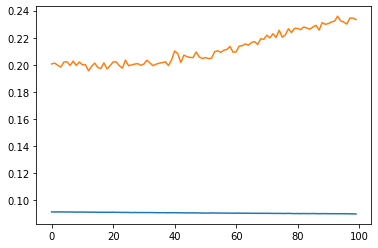

In [77]:
TTTT_loss = {}
VVVV_loss = {}

for i in range(len(Validation_loss)):
    
    TT_loss = Train_loss[i]
    TTT_loss = np.reshape(TT_loss, [TT_loss.shape[0] ,1])
    TTTT_loss[i] = TTT_loss 

    VV_loss = Validation_loss[i]
    VVV_loss = np.reshape(VV_loss, [VV_loss.shape[0] ,1])
    VVVV_loss[i] = VVV_loss
    
VVVVV_loss = np.concatenate([VVVV_loss[x] for x in VVVV_loss])
TTTTT_loss = np.concatenate([TTTT_loss[x] for x in TTTT_loss])

plt.plot(TTTTT_loss, label = 'Train Loss')
plt.plot(VVVVV_loss, label = 'Valid Loss')

In [78]:
test_predictions = model.predict(Test_MV_block)

mgc_head = test_predictions[:, 0:mgc_dim]
mgc_ref = Test_WAV_block[:, 0:mgc_dim]
from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)
print(MCD)

16.227424120450774


In [ ]:
MnM_VVVVV_loss
MnM_TTTTT_loss

In [23]:
x = np.arange(len(MnM_VVVVV_loss))


V_no_zero = MnM_VVVVV_loss[MnM_VVVVV_loss != 0.]
T_no_zero = MnM_TTTTT_loss[MnM_TTTTT_loss != 0.]

print(V_no_zero.shape)

(200,)


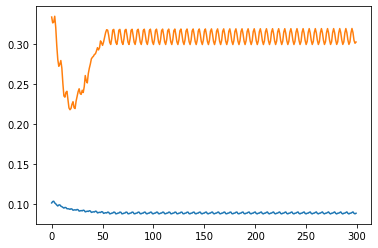

In [25]:
scale_ratio = len(MnM_VVVVV_loss) / V_no_zero.shape[0]
V_fixed = ndimage.zoom(V_no_zero, scale_ratio)
T_fixed = ndimage.zoom(T_no_zero, scale_ratio)


plt.plot(T_fixed, label = 'Train Loss')
plt.plot(V_fixed, label = 'Valid Loss')

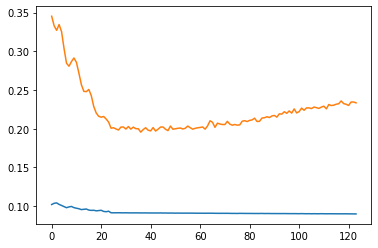

In [81]:

VV_fixed = np.reshape(V_fixed, [V_fixed.shape[0] ,1])
TT_fixed = np.reshape(T_fixed, [T_fixed.shape[0] ,1])

V_good = np.concatenate([VV_fixed, VVVVV_loss],0)
T_good = np.concatenate([TT_fixed, TTTTT_loss],0)

plt.plot(T_good, label = 'Train Loss')
plt.plot(V_good, label = 'Valid Loss')